<a href="https://colab.research.google.com/github/polnops/adiabatic_loading/blob/master/tweezer_move.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import os
import itertools
import numpy as np

import matplotlib.animation as animation
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from google.colab import drive
from matplotlib import cycler

drive.mount('/content/gdrive')

plt.style.use('classic')
%matplotlib inline

IPython_default = plt.rcParams.copy()
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none', 
       labelcolor='white', labelsize = 12,
       axisbelow=True, prop_cycle=colors)
       
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='white')
plt.rc('ytick', direction='out', color='white')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [67]:
class Dynamics1D(object):
    '''solves ODE for the dynamics of a single particle in a time-varing potential'''

    def __init__(self, n = int(5e3), t_len = 40, V0 = 200):
        
        self.n     = n
        self.t     = np.linspace(-t_len, t_len, n)      
        self.x     = np.empty_like(self.t)
        self.p     = np.empty_like(self.t)   
        self.V0    = V0
       
    
    def _rampOmega(self):
        self.omega = (self.omega_i + self.omega_f)/2.0 \
              - (self.omega_i - self.omega_f)/2.0* \
             np.arctan(self.t/self.tau)/(np.pi/2.0)  

    def _rampCenter(self):
        self.x0 = (self.x0_i + self.x0_f)/2.0 \
              - (self.x0_i - self.x0_f)/2.0* \
             np.arctan(self.t/self.tau)/(np.pi/2.0)  

    def V_trap(self, omega, x0, x):
        return -self.V0*np.exp(-(omega*(x-x0))**2)
 

    def dV_trap(self, omega, x0, x):
        return self.V0*2*(omega**2)*(x-x0)*np.exp(-(omega*(x-x0))**2)


    def _model(self, z, t, omega, x0):
        x, p = z
        dxdt = p
        dpdt = -self.dV_trap(omega,x0,x)
        return [dxdt, dpdt]

    def solveODE(self, omega_i = 1, omega_f = 1, 
                 tau = 10, z0 = [0, 0.25], 
                 x0_i = 0, x0_f = 1):
        
        self.x[0], self.p[0] = z0
        self.omega_i = omega_i
        self.omega_f = omega_f
        self.x0_i = x0_i
        self.x0_f = x0_f
        self.tau     = tau
        self._rampOmega()
        self._rampCenter()
        for i in range(1, self.n):
            tspan = [self.t[i-1], self.t[i]]
            z     = odeint(self._model, z0, tspan, args=(self.omega[i],self.x0[i]))
            self.x[i] = z[1][0]
            self.p[i] = z[1][1]
            z0        = z[1]

    def plot_xtrack(self):

        plt.figure(figsize=(15,2))
        plt.plot(self.t,self.x,label='atom')
        plt.plot(self.t,self.x0,'--',label='trap')
        plt.ylabel('position')
        plt.xlabel('time')
        plt.legend(loc='best')
        plt.show()

    def energy(self):
        self.KE       = 0.5*(self.p)**2
        self.PE       = self.V_trap(self.omega,self.x0,self.x)
        self.E_total  = self.KE + self.PE
        self.loss     = (self.E_total[-1] >= 0)

    def plotEnergy(self):
        self.energy()
        plt.figure(figsize=(10,2))
        plt.plot(self.t,self.KE ,label='K.E')
        plt.plot(self.t,self.PE,label='P.E')
        plt.plot(self.t,self.E_total,label='total',lw=4)
        plt.ylabel('energy')
        plt.xlabel('time')
        plt.legend(loc='best')
        plt.show()
        
    def plot_animation(self, savepath = 'adia1d.mp4'):
    
        width = 3
        fig = plt.figure()       
        ylim=(-self.V0, 0.25)

        ax = plt.axes(xlim=(-width, width), ylim=(-1.5, 0.25))
        line, = ax.plot([], [], lw=3)
        line2, = ax.plot([], [], marker='o',linestyle='None',markersize=12)

        def animate(i):

            xplot = np.linspace(-width,width,100)
            line.set_data(xplot, self.V_trap(self.omega[i],self.x0[i],xplot))
            line2.set_data(self.x[i], self.V_trap(self.omega[i],self.x0[i],self.x[i]))
            return line, line2

        anim = animation.FuncAnimation(fig, animate, frames=self.n, 
                                        interval=20, blit=True)
        anim.save(savepath)

        plt.show()

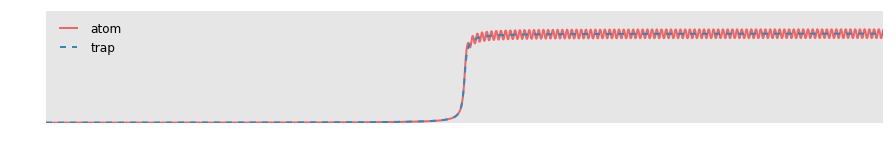

In [72]:
h1d = Dynamics1D(V0 = 200)
h1d.solveODE(x0_i = 0, x0_f = 20,tau = .198, z0 = [0,0])
#h1d.plot_xp()
#h1d.plotEnergy()
h1d.plot_xtrack()

In [ ]:
path = '/content/gdrive/My Drive/Atom_cavity/personal folders/Po/adiabatic_cooling'
os.chdir(path)
h1d.plot_animation(savepath = 'movefast.mp4')